#데이터톤

["훈민정음에 스며들다"-대화요약 역량평가](https://dacon.io/competitions/official/235818/overview/description)
<br/>[AI HUB 한국어 대화 요약](https://aihub.or.kr/aidata/30714)

**개발 환경**
<br/>**데이터 불러오기**
<br/>**전처리**
* Null 값 제외
* 동의어 제외

**토큰화**
* MeCab
* 명사/형태소 빈도수 csv 파일을 바탕으로 불용어 리스트 수정

**형태소 빈도수 csv 파일**
<br/>**명사 빈도수 csv 파일 (한 글자 단어 제외)**

**토큰화**
* MeCab

**MeCab + wordlist_to_indexlist**
* 정제
* 토큰화
* 단어 인덱스 생성
* 정수 인코딩

**시각화**
* 문장 길이 및 분포
* 적절한 최대 문장 길이 지정

* LDA 토픽 모델링
> 한 글자 단어 제외한 토큰화
<br/>훈련 및 시각화

* 워드클라우드 
> 한 글자 단어 제외한 토큰화
<br/>시각화

* Folium
> 행정구역(SHP) 데이터
<br/>행정구역명 데이터
<br/>행정구역별 지역명 빈도수 통계 데이터
<br/>행정구역별 지역명 빈도수 지도
<br/>버블 차트
<br/>히트맵

Okt. Mecab 비교
* Mecab으로 분리된 단어 개수
* 원문과 요약문 - 코사인 유사도

<br/>**참고문헌**

#개발 환경

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

In [ ]:
import konlpy
from konlpy.tag import Mecab

In [ ]:
print(pd.__version__)
print(np.__version__)
print(keras.__version__)
print(konlpy.__version__)

1.3.5
1.21.6
2.8.0
0.6.0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dataton/event_conversation.csv")

In [ ]:
data

,text
0,시스템 사진 비행시간봐 엄청나게 오래걸리네 비행기에서 하루 잔다고 생각해 그래 이...
1,아 그 호텔 나도 예약할 지경이야 이면 옆방으로다가요 그래도 괜찮은 호텔인데 뭐지...
2,오 이래도 되나 싶을정도로 신호에 걸리는군 내려서 뛰가는게 빠를듯 웨이팅 많아 걸...
3,으로 봄 일단 왜죠 나 월 일부터 쉰다구 근데 월 일이 목욜이라서 우리 이틀밖에 ...
4,근데 나는 원주간다 엥 금 갑자기 왜가 진짜 갑자기 감다 아빠가 갑자기 가쟤 사촌...
...,...
9995,코스요리나오면서 식보는거야 먹으면서동시에 엄청비싸겠다 코스면 모르지 식 다보고 가...
9996,삼성역 내일 볼까 오호 머리 다자르면 시 반쯤 될텐뎅 아닌가 시인가 삼성역에서 보...
9997,오늘데이트는 꽝인건가요 데이트는 강행입니다 맛난거 사드리지요 아니야 돈도없는데 집...
9998,너 졸업 여름에하지마 땀나서 머리 다 망함 이모티콘 그리고 졸업사진 찍으러가서 이...


In [ ]:
data.head

<bound method NDFrame.head of                                                    text
0      시스템 사진 비행시간봐 엄청나게 오래걸리네 비행기에서 하루 잔다고 생각해 그래 이...
1      아 그 호텔 나도 예약할 지경이야 이면 옆방으로다가요 그래도 괜찮은 호텔인데 뭐지...
2      오 이래도 되나 싶을정도로 신호에 걸리는군 내려서 뛰가는게 빠를듯 웨이팅 많아 걸...
3      으로 봄 일단 왜죠 나 월 일부터 쉰다구 근데 월 일이 목욜이라서 우리 이틀밖에 ...
4      근데 나는 원주간다 엥 금 갑자기 왜가 진짜 갑자기 감다 아빠가 갑자기 가쟤 사촌...
...                                                 ...
9995   코스요리나오면서 식보는거야 먹으면서동시에 엄청비싸겠다 코스면 모르지 식 다보고 가...
9996   삼성역 내일 볼까 오호 머리 다자르면 시 반쯤 될텐뎅 아닌가 시인가 삼성역에서 보...
9997   오늘데이트는 꽝인건가요 데이트는 강행입니다 맛난거 사드리지요 아니야 돈도없는데 집...
9998   너 졸업 여름에하지마 땀나서 머리 다 망함 이모티콘 그리고 졸업사진 찍으러가서 이...
9999   아 마쟈 이름 나 방탈출 취소 까먹음 갑자기 전화와서 놀랐네 언능 해야게따 아아아...

[10000 rows x 1 columns]>

In [ ]:
print(data[0:1]['text'])

0     시스템 사진 비행시간봐 엄청나게 오래걸리네 비행기에서 하루 잔다고 생각해 그래 이...
Name: text, dtype: object


#전처리 

##Null 값 제외

In [ ]:
data.dropna(axis=0, inplace=True)
print('Null 값 제거 후 전체 샘플 수:', (len(data)))

Null 값 제거 후 전체 샘플 수: 10000


##동의어 제외

In [ ]:
contractions = {"엄마": "어머니", "아빠": "아버지", "여보": "여봉", "친구": "칭구", "이번주": "요번주", "보자" : "보쟈", 
                "보자" : "보장", "아마": "아마도", "근데": "그런데", "그냥": "구냥", "그니까": "그러니까", "머": "머머",
                "얼른": "언능", "언제": "언제쯤", "괜찮아": "괜츈", "오키오키": "오키도키", "알았어": "아라써",
                "알았어": "알써", "그래": "그려", "아냐": "아냐아냐", "어차피": "어짜피", "마자": "마쟈", "조아": "죠아",
                "허허허": "허허", "흠": "훔", "미안": "미안해"}
                
print("정규화 사전 수: ", len(contractions))

정규화 사전 수:  24


In [ ]:
def preprocess_sentence(sentence):
  sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
  return sentence

In [ ]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", clean_text[:1])

text 전처리 후 결과:  [' 시스템 사진 비행시간봐 엄청나게 오래걸리네 비행기에서 하루 잔다고 생각해 그려 이때 아니면 언제쯤 가보겠냐 이번이 기회다 그려 바로 결제 고고 ']


In [ ]:
data['text'] = clean_text

#토큰화

##MeCab

In [ ]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
def mecab_morphs(data, num_words=10000):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
  
    X_mecab_morph_list = []
    for sentence in data['text']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_mecab_morph_list.append(temp_X)
    return X_mecab_morph_list

In [ ]:
X_mecab_morphs = mecab_morphs(data) 

In [ ]:
type(X_mecab_morphs[:1])

list

In [ ]:
X_mecab_morphs[1:2][0]

In [ ]:
for i in range(0, len(X_mecab_morphs[:1][0])):
  if i % 4 == 0 :
    print() 
  print(X_mecab_morphs[:1][0][i], end=' ')


시스템 사진 비행 시간 
봐 엄청나 게 오래 
걸리 네 비행기 에서 
하루 잔다고 생각 해 
그려 이때 아니 면 
언제 쯤 보 겠 
냐 이번 기회 다 
그려 바로 결제 고고 

#형태소 빈도수 csv 파일

In [ ]:
import itertools
from collections import Counter

In [ ]:
X_mecab_morphs = mecab_morphs(data)

In [ ]:
onedim_morph_words = list(itertools.chain(*X_mecab_morphs))

In [ ]:
morph_count = Counter(onedim_morph_words)
morph_words = dict(morph_count.most_common())

In [ ]:
type(morph_words)

dict

In [ ]:
morph_words['왜']

921

In [ ]:
morph_series = pd.Series(morph_words)

In [ ]:
morph_series

고     10250
나      8932
하      7875
아      6162
어      5998
      ...  
땀나        1
망함        1
학위        1
운젠        1
졸사        1
Length: 21243, dtype: int64

In [ ]:
morph_df = pd.DataFrame(morph_series).reset_index()
morph_df.columns = ['형태소', '빈도수']

In [ ]:
morph_df.head()

,형태소,빈도수
0,고,10250
1,나,8932
2,하,7875
3,아,6162
4,어,5998


In [ ]:
morph_df.to_csv('/content/drive/MyDrive/Dataton/morph_dict.csv', index=False)

In [ ]:
morph_dict_path = '/content/drive/MyDrive/Dataton/morph_dict.csv'
morph_dict_csv = pd.read_csv(morph_dict_path)

In [ ]:
morph_dict_csv

,형태소,빈도수
0,고,10250
1,나,8932
2,하,7875
3,아,6162
4,어,5998
...,...,...
21238,땀나,1
21239,망함,1
21240,학위,1
21241,운젠,1


#명사 빈도수 csv 파일 (한 글자 단어 제외)

곰, 문, 달, 발 등 길이가 1인 단어는 제외

In [ ]:
def mecab_nouns_list(data):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
    temp_X_list = []
    for i in range(len(data['text'])):
      temp_X = tokenizer.nouns(data['text'][i])
      two = [x for x in temp_X if len(x) > 1 and not x in stopwords]
      temp_X_list.append(two)
         
    return temp_X_list

In [ ]:
X_mecab_nouns_two = mecab_nouns_list(data) 

In [ ]:
import itertools
from collections import Counter

In [ ]:
onedim_X_mecab_nouns_two = list(itertools.chain(*X_mecab_nouns_two))

In [ ]:
nouns_count = Counter(onedim_X_mecab_nouns_two)
nouns_words = dict(nouns_count.most_common())

In [ ]:
type(nouns_words)

dict

In [ ]:
nouns_words['서울']

370

In [ ]:
nouns_series = pd.Series(nouns_words)

In [ ]:
nouns_series

이름      4800
우리      2051
시간      1776
어디      1374
이모티콘    1311
        ... 
부작용        1
강행         1
학위         1
운젠         1
졸사         1
Length: 12155, dtype: int64

In [ ]:
nouns_df = pd.DataFrame(nouns_series).reset_index()
nouns_df.columns = ['명사', '빈도수']

In [ ]:
nouns_df.head()

,명사,빈도수
0,이름,4800
1,우리,2051
2,시간,1776
3,어디,1374
4,이모티콘,1311


In [ ]:
nouns_df.to_csv('/content/drive/MyDrive/Dataton/nouns_dict.csv', index=False)

In [ ]:
nouns_dict_path = '/content/drive/MyDrive/Dataton/nouns_dict.csv'
nouns_dict_csv = pd.read_csv(nouns_dict_path)

In [ ]:
nouns_dict_csv

,명사,빈도수
0,이름,4800
1,우리,2051
2,시간,1776
3,어디,1374
4,이모티콘,1311
...,...,...
12152,부작용,1
12153,강행,1
12154,학위,1
12155,운젠,1


#토큰화

##MeCab

##명사/형태소 빈도수 csv 파일을 바탕으로 불용어 리스트 수정

In [ ]:
tokenizer = Mecab()
revised_stopwords = ['의','가','이','은','들','는','좀','잘','걍','과''도','를','으로','자','에','와','한','하다'
,' 박 일', '이름', '계정', '전번', '주소', '소속', '기타', '이모티콘', '시스템 사진',
' 월 일', ' 일날', ' 시', ' 시 반', ' 분', ' 이랑', ' 랑',]

In [ ]:
def revised_mecab_morphs(data, num_words=10000):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
  
    X_mecab_morph_list = []
    for sentence in data['text']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in revised_stopwords] 
        X_mecab_morph_list.append(temp_X)
    return X_mecab_morph_list

In [ ]:
revised_X_mecab_morphs = revised_mecab_morphs(data) 

In [ ]:
type(revised_X_mecab_morphs[:1])

list

In [ ]:
revised_X_mecab_morphs[1:2][0]

In [ ]:
for i in range(0, len(revised_X_mecab_morphs[:1][0])):
  if i % 4 == 0 :
    print() 
  print(revised_X_mecab_morphs[:1][0][i], end=' ')


시스템 사진 비행 시간 
봐 엄청나 게 오래 
걸리 네 비행기 에서 
하루 잔다고 생각 해 
그려 이때 아니 면 
언제 쯤 보 겠 
냐 이번 기회 다 
그려 바로 결제 고고 

#MeCab + wordlist_to_indexlist

In [ ]:
def revised_Tokenizer(data, num_words=10000):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
  
    X = []
    for sentence in data['text']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in revised_stopwords] 
        X.append(temp_X)
    
    words = np.concatenate(X).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X = list(map(wordlist_to_indexlist, X))
        
    return X, word_to_index

###정제

drop_duplicates는 데이터의 중복을 제거한다.
<br/>dropna는 NaN 결측치를 제거한다.

###토큰화

tokenizer는 Mecab 형태소 분석기를 이용해 토큰화하고
<br/>불용어(Stopwords)는 토큰화에 포함시키지 않는다.

###단어 인덱스 생성

concatenate는 단어 numpy 배열을 하나로 합친다.
 <br/>counter는 단어의 수를 합산한다.
 <br/>enumerate는 반복문 사용 시 몇 번째 반복문인지 확인한다.
 <br/>이를 통해 단어 사전 word_to_index를 구성한다.
 <br/>텍스트 스트링을 사전 인덱스 스트링으로 변환한다.

In [ ]:
X, word_to_index = revised_Tokenizer(data) 

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
index_to_word

##정수 인코딩

In [ ]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

In [ ]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [ ]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) 

In [ ]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#시각화

##대화 길이 및 분포

In [ ]:
total_data_text = list(X)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

대화 개수 :  10000
최대 길이 :  257
최소 길이 :  8
평균 :  49.8887
표준편차 :  22.35865184464394


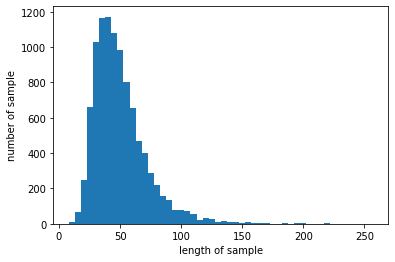

In [ ]:
print('대화 개수 : ',  len(num_tokens))
print('최대 길이 : ', np.max(num_tokens))
print('최소 길이 : ', np.min(num_tokens))
print('평균 : ', np.mean(num_tokens))
print('표준편차 : ', np.std(num_tokens))

plt.hist([s for s in num_tokens if s >= 1], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

최대 : 257
평균 : 49.8887
중앙값 : 45.0


<function matplotlib.pyplot.show>

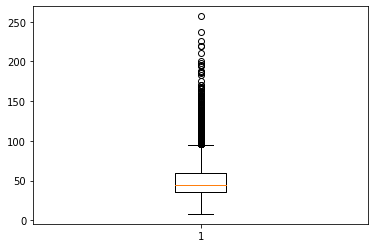

In [ ]:
print('최대 : {}'.format(np.max(num_tokens)))
print('평균 : {}'.format(np.mean(num_tokens)))
print('중앙값 : {}'.format(np.median(num_tokens)))

plt.boxplot(num_tokens)
plt.show

##적절한 최대 대화 길이 지정

In [ ]:
max_tokens = np.mean(num_tokens) + np.std(num_tokens)
text_max_len = int(max_tokens)
print('pad_sequences maxlen : ', text_max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  72
전체 문장의 0.8739%가 maxlen 설정값 이내에 포함됩니다. 


평균에 표준편차를 더한 것으로 최대 문장 길이를 지정한다.

이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인한다.

##LDA 토픽 모델링

사람들은 행사의 어떤 주제에 대해 관심을 갖는가?
<br/>대화 텍스트에서 중심 키워드를 추출하여 사람들의 관심사를 알아본다.

**참고사이트**
<br/>[유원준 외 1명, 딥러닝을 이용한 자연어 처리 입문, wikidocs, 2022](https://wikidocs.net/30708)

토픽 모델링은 문서의 집합에서 토픽을 찾아내는 프로세스를 말한다.
<br/>이는 검색 엔진, 고객 민원 시스템 등과 같이 문서의 주제를 알아내는 일이 중요한 곳에서 사용된다.
<br/>잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)은 토픽 모델링의 대표적인 알고리즘이다. 

In [ ]:
tokenizer = Mecab()
revised_stopwords = ['의','가','이','은','들','는','좀','잘','걍','과''도','를','으로','자','에','와','한','하다'
,' 박 일', '이름', '계정', '전번', '주소', '소속', '기타', '이모티콘', '시스템 사진',
' 월 일', ' 일날', ' 시', ' 시 반', ' 분', ' 이랑', ' 랑',]

In [ ]:
len(data['text'])

10000

###한 글자 단어 제외한 토큰화
<br/>곰, 문, 달, 발 등 길이가 1인 단어는 제외

In [ ]:
tokenizer = Mecab()
revised_stopwords = ['의','가','이','은','들','는','좀','잘','걍','과''도','를','으로','자','에','와','한','하다'
,' 박 일', '이름', '계정', '전번', '주소', '소속', '기타', '이모티콘', '시스템 사진',
' 월 일', ' 일날', ' 시', ' 시 반', ' 분', ' 이랑', ' 랑',]

In [ ]:
def revised_mecab_nouns_list(data):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
    temp_X_list = []
    for i in range(len(data['text'])):
      temp_X = tokenizer.nouns(data['text'][i])
      two = [x for x in temp_X if len(x) > 1 and not x in revised_stopwords]
      temp_X_list.append(two)
         
    return temp_X_list

In [ ]:
revised_X_mecab_nouns_two = revised_mecab_nouns_list(data) 

자료형은 중첩리스트이다.

[ [], [], [], [] ]

In [ ]:
type(revised_X_mecab_nouns_two)

list

In [ ]:
type(revised_X_mecab_nouns_two[:2])

list

In [ ]:
print(revised_X_mecab_nouns_two[:2], end='')

[['시스템', '사진', '비행', '시간', '비행기', '하루', '생각', '이때', '언제', '이번', '기회', '결제', '고고'], ['호텔', '예약', '지경', '옆방', '가요', '호텔', '호텔', '어디']]

In [ ]:
type(revised_X_mecab_nouns_two[:2][0][0])

str

In [ ]:
print(revised_X_mecab_nouns_two[:1][0][:3], end='')

['시스템', '사진', '비행']

단어 단위로 토크나이즈한 토큰 집합을 가져온다.

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(revised_X_mecab_nouns_two)
corpus = [dictionary.doc2bow(text) for text in revised_X_mecab_nouns_two]
print(corpus[1]) # 수행된 결과에서 두번째 대화 출력. 첫번째 대화의 인덱스는 0

[(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3)]


각 단어에 정수 인코딩을 하는 동시에, 각 뉴스에서의 단어의 빈도수를 기록한다.
<br/>여기서는 각 단어를 (word_id, word_frequency)의 형태로 바꾼다.

 word_id는 단어가 정수 인코딩된 값
 <br/>word_frequency는 해당 뉴스에서의 해당 단어의 빈도수를 의미한다.

In [ ]:
print(dictionary[13])

가요


두 번째 대화에서 12로 인코딩된 숫자가 1번 나왔다.

In [ ]:
len(dictionary)

12147

한 글자 단어 제외 시 총 학습된 단어의 개수 12147개

In [ ]:
def revised_mecab_nouns_list(data, num_words=10000):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
  
    X_mecab_nouns_list2 = []
    for sentence in data['text']:
        temp_X = tokenizer.nouns(sentence) 
        temp_X = [word for word in temp_X if not word in revised_stopwords] 
        X_mecab_nouns_list2.append(temp_X)
    return X_mecab_nouns_list2

In [ ]:
revised_X_mecab_nouns_included_one = revised_mecab_nouns_list(data) 

In [ ]:
from gensim import corpora
dictionary_included_one = corpora.Dictionary(revised_X_mecab_nouns_included_one)
corpus_included_one = [dictionary.doc2bow(text) for text in revised_X_mecab_nouns_included_one]

In [ ]:
len(dictionary_included_one)

13198

한 글자 단어 포함시 총 학습된 단어의 개수 13198개

In [ ]:
len(dictionary_included_one) - len(dictionary)

1051

LDA를 위해 제외된 한 글자 단어의 개수는 1051개

###훈련 및 시각화

In [ ]:
import gensim
NUM_TOPICS = 40 # 40개의 토픽, k=40
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)

In [ ]:
for topic in topics:
    print(topic)

(35, '0.053*"강릉" + 0.045*"강남" + 0.038*"어디" + 0.028*"담날"')
(26, '0.089*"고민" + 0.082*"일정" + 0.063*"투어" + 0.037*"때문"')
(4, '0.075*"공항" + 0.063*"생일" + 0.040*"여수" + 0.038*"여유"')
(37, '0.148*"출발" + 0.093*"버스" + 0.068*"도착" + 0.031*"학교"')
(25, '0.053*"쇼핑" + 0.043*"카톡" + 0.042*"우리" + 0.035*"방콕"')
(2, '0.205*"시스템" + 0.202*"사진" + 0.065*"여기" + 0.050*"검색"')
(21, '0.112*"조아" + 0.036*"이후" + 0.027*"산책" + 0.024*"이야기"')
(23, '0.188*"예약" + 0.076*"전화" + 0.045*"오키" + 0.040*"하루"')
(14, '0.043*"펜션" + 0.035*"수영장" + 0.032*"베트남" + 0.025*"출구"')
(12, '0.070*"수업" + 0.056*"회사" + 0.041*"다행" + 0.040*"동네"')
(10, '0.107*"준비" + 0.089*"영화" + 0.086*"시반" + 0.063*"시간"')
(31, '0.185*"도착" + 0.053*"병원" + 0.048*"맛집" + 0.024*"어디"')
(9, '0.194*"카페" + 0.062*"어디" + 0.035*"거기" + 0.027*"음식"')
(0, '0.257*"언니" + 0.068*"얘기" + 0.034*"일본" + 0.029*"오랜만"')
(39, '0.100*"취소" + 0.035*"인천" + 0.029*"전주" + 0.028*"순천"')
(18, '0.191*"친구" + 0.058*"누구" + 0.019*"코스" + 0.017*"세상"')
(5, '0.089*"구래" + 0.032*"한국" + 0.028*"호선" + 0.028*"요기"')
(34, '0.231*"저

In [ ]:
pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


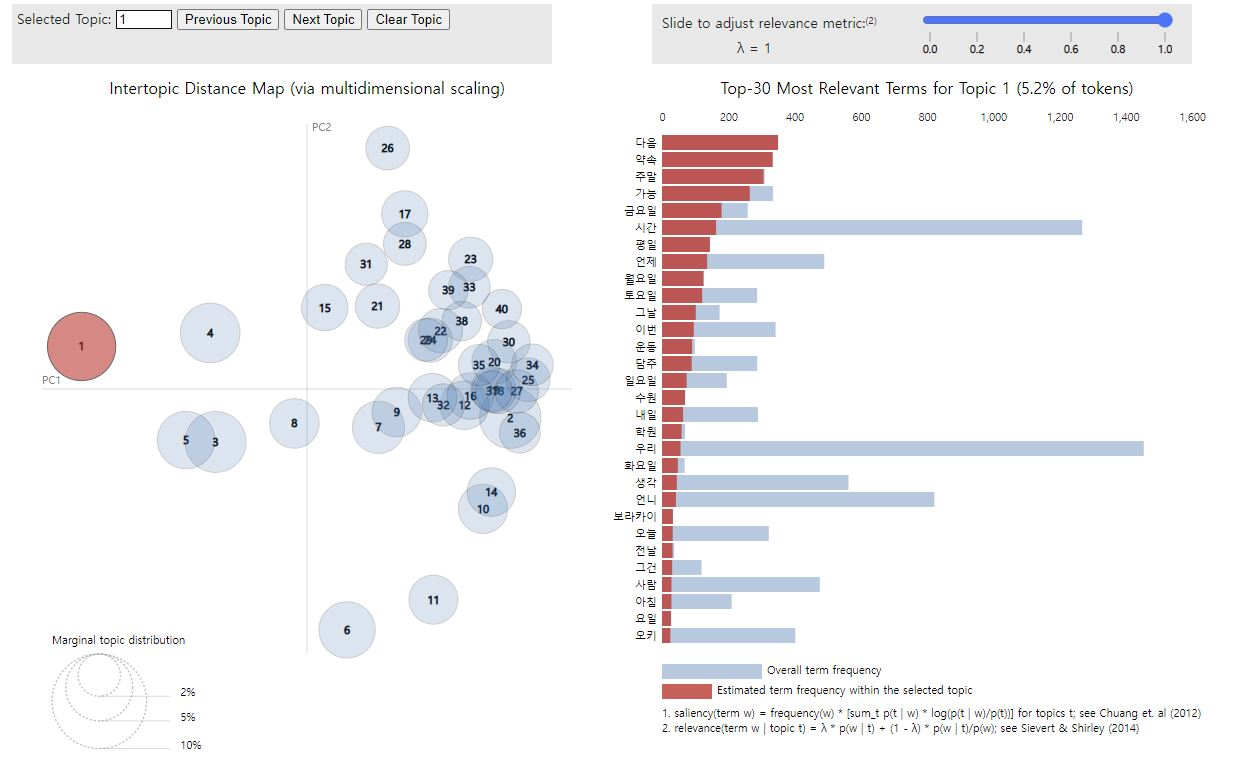

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/Dataton/Mecab_LDA_Topic1.JPG", width= 1236, height = 771)

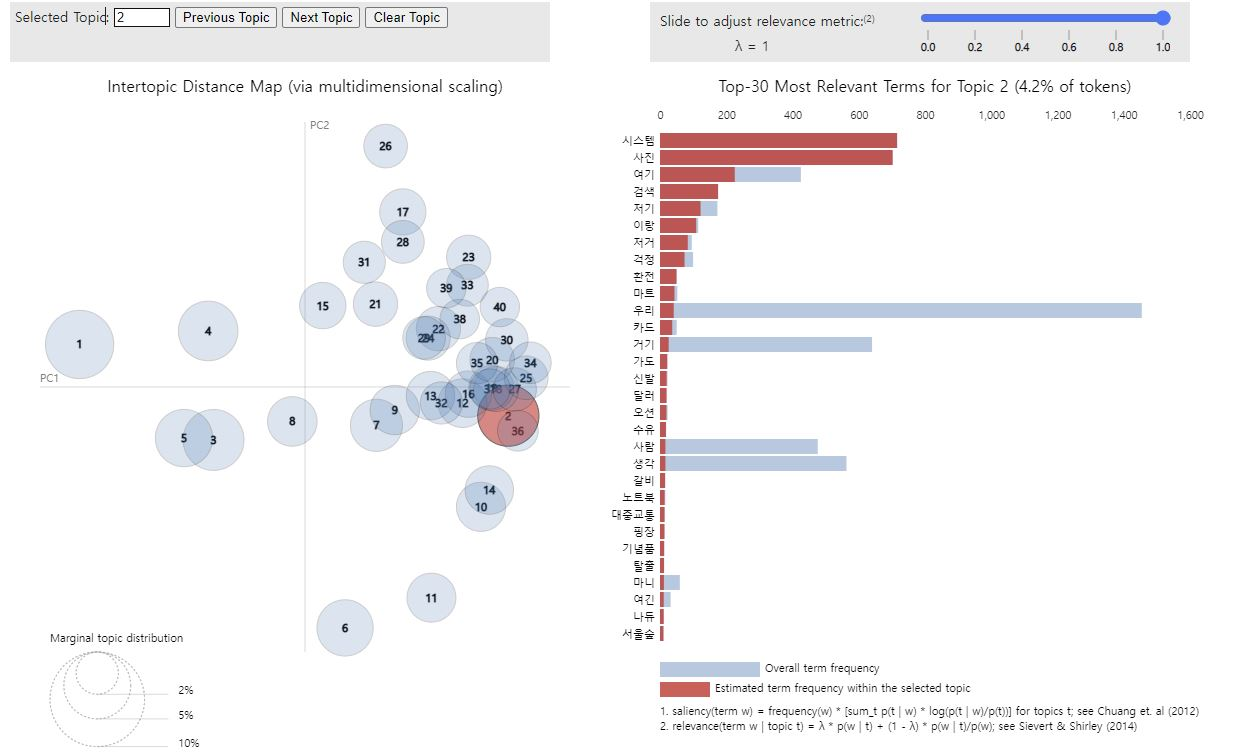

In [ ]:
Image("/content/drive/MyDrive/Dataton/Mecab_LDA_Topic2.JPG", width= 1252, height = 756)

In [ ]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [ ]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,17.0,0.1701,"[(2, 0.14874578), (4, 0.09404337), (7, 0.07324..."
1,1,6.0,0.3667,"[(6, 0.366657), (19, 0.30556488), (23, 0.22500..."
2,2,25.0,0.4120,"[(3, 0.15576924), (11, 0.07189979), (25, 0.412..."
3,3,7.0,0.6050,"[(7, 0.605), (28, 0.20499997)]"
4,4,23.0,0.3428,"[(0, 0.15575092), (15, 0.18057851), (23, 0.342..."
5,5,28.0,0.7179,"[(0, 0.14642857), (28, 0.7178572)]"
6,6,31.0,0.2415,"[(12, 0.08603513), (15, 0.1134788), (17, 0.090..."
7,7,0.0,0.5477,"[(0, 0.5477273), (6, 0.09318182), (7, 0.093181..."
8,8,21.0,0.4624,"[(16, 0.15613969), (21, 0.46235713), (24, 0.13..."
9,9,36.0,0.3095,"[(2, 0.13243282), (5, 0.16042434), (16, 0.1262..."


##워드클라우드

**참고 사이트**
<br/>[카톡 데이터로 워드 클라우드 그리기](https://m.blog.naver.com/nilsine11202/221834254905)

###한 글자 단어 제외한 토큰화
<br/>곰, 문, 달, 발 등 길이가 1인 단어는 제외

In [ ]:
tokenizer = Mecab()
revised_stopwords = ['의','가','이','은','들','는','좀','잘','걍','과''도','를','으로','자','에','와','한','하다'
,' 박 일', '이름', '계정', '전번', '주소', '소속', '기타', '이모티콘', '시스템 사진',
' 월 일', ' 일날', ' 시', ' 시 반', ' 분', ' 이랑', ' 랑',]

In [ ]:
def revised_mecab_nouns_list(data):
    data.drop_duplicates(subset=['text'], inplace=True)
    data = data.dropna(how = 'any') 
    temp_X_list = []
    for i in range(len(data['text'])):
      temp_X = tokenizer.nouns(data['text'][i])
      two = [x for x in temp_X if len(x) > 1 and not x in revised_stopwords]
      temp_X_list.append(two)
         
    return temp_X_list

In [ ]:
revised_X_mecab_nouns_two = revised_mecab_nouns_list(data) 

In [ ]:
import itertools
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

In [ ]:
revised_onedim_X_mecab_nouns_two = list(itertools.chain(*revised_X_mecab_nouns_two))

하나의 리스트로 모은다.

In [ ]:
count = Counter(revised_onedim_X_mecab_nouns_two)
words = dict(count.most_common())

In [ ]:
print(words.keys(), end='')

In [ ]:
print(words.values(), end='')

###시각화

In [ ]:
%matplotlib inline 
import matplotlib 
from IPython.display import set_matplotlib_formats 
matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq  

In [ ]:
font = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'

코랩에서 한글 표기를 위해 폰트 설치

In [ ]:
wordcloud = WordCloud(font_path=font,
                      background_color='white', colormap = "hot",width=3000, height=2000).generate_from_frequencies(words) 

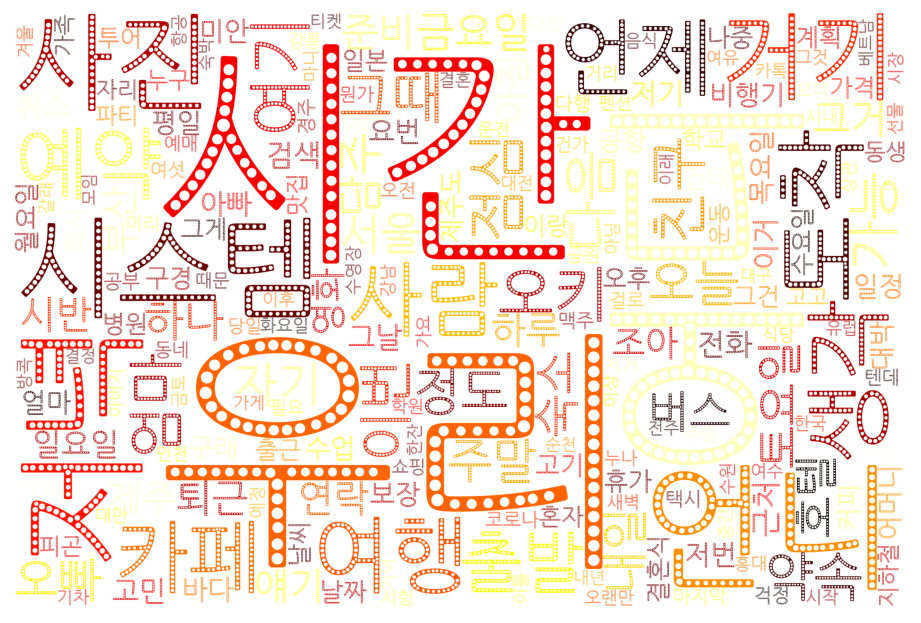

In [ ]:
plt.imshow(wordcloud) 
figure = plt.gcf() # get current figure
figure.set_size_inches(8, 6)
plt.axis('off') 
plt.show()

##Folium

folium를 활용해 지도에 지역구 영역을 표시하고 행사 현황을 시각화해보자.

행사 현황 = 총 대화에서 지역명이 언급된 횟수

예를 들어 데이터에서 서울이 45번, 부산이 20번 언급됐으면
<br/>지도에서 서울이 부산보다 더 진하게 표시된다.

위치정보와 지역명 빈도 데이터 병합

**참고 사이트**
<br/>[전국 인구 현황 지도 시각화](https://mkjjo.github.io/python/2019/08/18/korea_population.html)
<br/>[Folium을 이용한 데이타 시각화](https://blog.naver.com/PostView.nhn?blogId=kcchang61&logNo=221350672356)
<br/>[대한민국 최신 행정구역(SHP) 다운로드](http://www.gisdeveloper.co.kr/?p=2332)
<br/>[대한민국 행정구역 경계 JSON 파일 변환 및 다운받기](https://yeomss.tistory.com/267)
<br/>[대한민국 행정구역(시도, 시군구) GeoJSON 파일 다운로드 및 SHP 파일 단순화 후 변환 방법 설명](https://neurowhai.tistory.com/350)

In [ ]:
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import os
import webbrowser
import folium
from folium import plugins

In [ ]:
print(folium.__version__)

0.8.3


####행정구역(SHP) 데이터

행정구역 시/군/구 정보를 담고 있는 Json 파일 불러오기

In [ ]:
state_geo = '/content/drive/MyDrive/Dataton/TL_SCCO_SIG.json'

####행정구역명 데이터

[통계청 오픈 데이터](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1BPA002&vw_cd=&list_id=&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=K1)에서 지역명 리스트 가져오기

In [ ]:
population_path = '/content/drive/MyDrive/Dataton/행정구역_시군구_별_주민등록세대수_20220601135321.csv'
population_csv = pd.read_csv(population_path, encoding='CP949')

In [ ]:
area_csv = population_csv['행정구역(시군구)별']

In [ ]:
area_csv.to_csv("/content/drive/MyDrive/Dataton/area.csv", index = False)

In [ ]:
area_path = '/content/drive/MyDrive/Dataton/area.csv'
area_data = pd.read_csv(area_path)

In [ ]:
area_data.head

<bound method NDFrame.head of     행정구역(시군구)별
0           전국
1        서울특별시
2          종로구
3           중구
4          용산구
..         ...
287        거창군
288        합천군
289    제주특별자치도
290        제주시
291       서귀포시

[292 rows x 1 columns]>

In [ ]:
len(area_data)

292

In [ ]:
area_data[1:5]

,행정구역(시군구)별
1,서울특별시
2,종로구
3,중구
4,용산구


####행정구역별 지역명 빈도수 통계 데이터

행정구역별 지역명 언급 빈도 통계 데이터 csv 파일 만들기

In [ ]:
count = Counter(revised_onedim_X_mecab_nouns_two)
words = dict(count.most_common())

In [ ]:
nouns_words_series = pd.Series(words)

In [ ]:
nouns_words_series

우리     2051
시간     1776
어디     1374
언니     1120
저녁     1066
       ... 
부작용       1
강행        1
학위        1
운젠        1
졸사        1
Length: 12147, dtype: int64

In [ ]:
nouns_words_df = pd.DataFrame(nouns_words_series).reset_index()
nouns_words_df.columns = ['명사', '빈도수']

In [ ]:
nouns_words_df.to_csv('/content/drive/MyDrive/Dataton/nouns_words_dict.csv', index=False)

In [ ]:
nouns_words_dict_path = '/content/drive/MyDrive/Dataton/nouns_words_dict.csv'
nouns_words_dict_csv = pd.read_csv(nouns_words_dict_path)

In [ ]:
nouns_words_dict_csv[:3]

,명사,빈도수
0,우리,2051
1,시간,1776
2,어디,1374


In [ ]:
nouns_words_dict_csv[nouns_words_dict_csv['명사'].str.contains('제주', na = False)]

,명사,빈도수
49,제주,287
76,제주도,191
1726,제주항공,8


In [ ]:
sum(nouns_words_dict_csv[nouns_words_dict_csv['명사'].str.contains('제주', na = False)]['빈도수'])

486

In [ ]:
area_name_list = ['서울', '종로', '용산', '성동', '광진', '동대문', '중랑', '성북', '강북', '도봉', '노원', '은평', '서대문', '마포', '양천',
'강서', '구로', '금천', '영등포', '동작', '관악', '서초', '강남', '송파', '강동', '부산', '영도', '동래', '해운대', '사하', '금정', '연제', 
'사상', '기장', '대구', '수성', '달서', '달성', '인천', '미추홀', '연수', '남동', '부평', '계양', '강화', '옹진', '광주', '광산', '대전', '유성',
'대덕', '울산', '울주', '세종', '수원', '장안', '권선', '팔달', '영통', '성남', '중원', '분당', '의정부', '안양', '만안', '동안', '부천', '광명', 
'평택', '동두천', '안산', '상록', '단원', '고양', '덕양', '일산', '과천', '구리', '남양주', '오산', '시흥', '군포', '의왕', '하남', '용인', '처인',
'기흥', '수지', '파주', '이천', '안성', '김포', '화성', '광주', '양주', '포천', '여주', '연천', '가평', '양평', '춘천', '원주', '강릉', '동해', '태백',
'속초', '삼척', '홍천', '횡성', '영월', '평창', '정선', '철원', '화천', '양구', '인제', '고성', '양양', '청주', '상당', '흥덕', '청원', '충주',
'제천', '보은', '옥천', '영동', '증평', '진천', '괴산', '음성', '단양', '천안', '공주', '보령', '아산', '서산', '논산', '계룡', '당진', '금산', '부여', '서천',
'청양', '홍성', '예산', '태안', '전주', '완산', '덕진', '군산', '익산', '정읍', '남원', '김제', '완주', '진안', '무주', '임실', '순창', '고창', '부안',
'목포', '여수', '순천', '나주', '광양', '담양', '곡성', '구례', '고흥', '보성', '화순', '장흥', '강진', '해남', '영암', '무안', '함평', '영광', '장성',
'완도', '진도', '신안', '포항', '경주', '김천', '안동', '구미', '영주', '영천', '상주', '문경', '경산', '군위', '의성', '청송', '영양', '영덕', '청도',
'고령', '성주', '칠곡', '예천', '봉화', '울진', '울릉', '창원', '의창', '성산', '영양', '영덕', '청도', '고령', '성주', '칠곡', '마산', '진해',
'진주', '통영', '사천', '김해', '밀양', '거제', '양산', '의령', '함안', '창녕', '고성', '남해', '하동', '산청', '함양', '거창', '합천', '제주', '서귀포']

In [ ]:
len(area_name_list)

237

In [ ]:
area_df = pd.DataFrame({'지역명': ['지역'],
                             '빈도수':[0]})

In [ ]:
area_df2 = pd.DataFrame({'지역명': ['지역'],
                             '빈도수':[0]})

In [ ]:
for i in range(236):
  area_df = area_df.append(area_df2)

In [ ]:
len(area_df)

237

In [ ]:
for i in range(len(area_name_list)):
  area_df['지역명'][i:i+1] = area_name_list[i]
  area_df['빈도수'][i:i+1]= sum(nouns_words_dict_csv[nouns_words_dict_csv['명사'].str.contains(area_name_list[i], na = False)]['빈도수'])

In [ ]:
area_df

,지역명,빈도수
0,서울,412
0,종로,19
0,용산,25
0,성동,3
0,광진,0
...,...,...
0,함양,2
0,거창,0
0,합천,5
0,제주,486


In [ ]:
area_descend_df = area_df.sort_values(by = ['빈도수'], ascending=[False])

In [ ]:
area_descend_df.to_csv('/content/drive/MyDrive/Dataton/area_name_frequency_dict.csv', index=False)

In [ ]:
area_code_list = [11140, 11110, 11170, 11200, 11215, 11230, 11260, 11290, 11305, 11320, 11350, 11380, 11410, 11440, 11470,
11500, 11530, 11545, 11560, 11590, 11620, 11650, 11680, 11710, 11740 , 26110, 26200, 26260, 26350, 26380, 26410, 26470,
26530, 26710, 27110, 27290, 27290, 27710, 28110, 28170, 28185, 28200, 28237, 28245, 28710, 28720, 29110, 29200, 30140, 30200,
30230, 31110, 31710, 29010, 41110, 41111, 41113, 41115, 41117, 41130, 41133, 41135, 41150, 41170, 41171, 41173, 41190, 41210, 
41220, 41250, 41270, 41271, 41273, 41280, 41281, 41285, 41290, 41310, 41360, 41370, 41390, 41410, 41430, 41450, 41460, 41461,
41463, 41465, 41480, 41500, 41550, 41570, 41590, 41610, 41630, 41650, 41730, 41800, 41820, 41830, 42110, 42130, 42150, 42170, 42190,
42210, 42230, 42720, 42730, 42750, 42760, 42770, 42780, 42790, 42800, 42810, 42820, 42830, 43110, 43111, 43113, 43710, 43130,
43150, 43720, 43730, 43740, 43745, 43750, 43760, 43770, 43800, 44130, 44150, 44180, 44200, 44210, 44230, 44250, 44830, 44710, 44760, 44770,
44790, 44800, 44810, 44825, 45110, 45111, 45113, 45130, 45140, 45180, 45190, 45210, 45710, 45720, 45730, 45750, 45770, 45790, 45800,
46110, 46130, 46150, 46170, 46230, 46710, 46720, 46730, 46770, 46780, 46790, 46800, 46810, 46820, 46830, 46840, 46860, 46870, 46880,
46890, 46900, 46910, 47110, 47130, 47150, 47170, 47190, 47210, 47230, 47250, 47280, 47290, 47720, 47730, 47750, 47760, 47770, 47820,
47830, 47840, 47850, 47900, 47920, 47930, 47940, 48120, 48121, 48123, 47760, 47770, 47820, 47830, 47840, 47850, 48125, 48129,
48170, 48220, 48240, 48250, 48270, 48310, 48330, 48720, 48730, 48740, 48820, 48840, 48850, 48860 , 48870, 48880, 48890, 50110, 50130]

In [ ]:
len(area_code_list)

237

In [ ]:
for i in range(len(area_name_list)):
  area_df['지역명'][i:i+1] = area_code_list[i]

In [ ]:
area_df

,지역명,빈도수
0,11140,412
0,11110,19
0,11170,25
0,11200,3
0,11215,0
...,...,...
0,48870,2
0,48880,0
0,48890,5
0,50110,486


###

In [ ]:
area_df['지역명'] = area_df.지역명.map(lambda x : str(x).zfill(5))

###행정구역별 지역명 빈도수 지도

In [ ]:
basic_map = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7.4)

basic_map.choropleth(
    geo_data=state_geo,
    name='지역명 언급 빈도수',
    data=area_df,
    columns=['지역명', '빈도수'],
    key_on='feature.properties.SIG_CD',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
    color = 'gray',
    legend_name = 'Frequency'
)

folium.LayerControl().add_to(basic_map)

basic_map 

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [ ]:
basic_map.save('/content/drive/MyDrive/Dataton/area_name_frequency_basic_map.html')

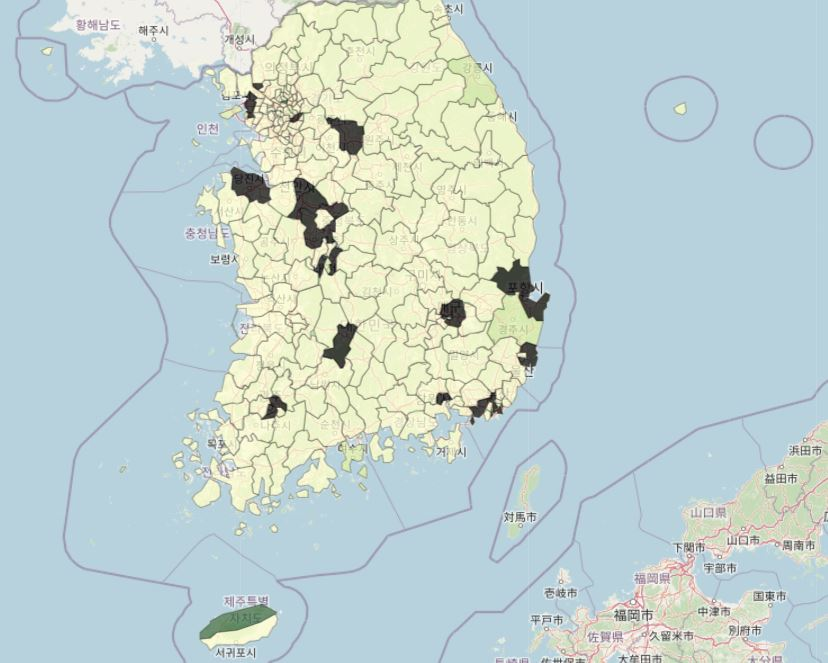

In [ ]:
Image("/content/drive/MyDrive/Dataton/Mecab_Folium_basic_map.JPG", width= 828, height = 663)

###버블 차트

In [ ]:
import json
json_data=open(state_geo).read()
jsonResult = json.loads(json_data)

In [ ]:
def center_calc(points_df):
    x = points_df.x
    y = points_df.y

    X = (max(x)+min(x))/2.
    Y = (max(y)+min(y))/2.

    return X, Y

In [ ]:
# 다중 Array 구조 이중으로 변환
def points_array(points):

    final_points = []

    for x in range(0, len(points)):

        if len(points[x]) == 2:
            final_points.append(points[x])
        else:
            target = points[x]
            for y in range(0, len(target)):
                final_points.append(target[y])

    return final_points

In [ ]:
center_locations = pd.DataFrame()
codes = []
names = []
x_list = []
y_list = []
for x in range(0, len(jsonResult['features'])):
    code = jsonResult['features'][x]['properties']['SIG_CD']
    name = jsonResult['features'][x]['properties']['SIG_KOR_NM']
    # 중앙값 생성
    points = jsonResult['features'][x]['geometry']['coordinates'][0]
    points = points_array(points)
    points_df = pd.DataFrame(points)
    points_df.columns = ['x','y']
    X, Y = center_calc(points_df)

    # 결과
    codes.append(code)
    names.append(name)
    x_list.append(X)
    y_list.append(Y)

# 데이터 프레임 생성
center_locations['지역명'] = codes
center_locations['NAME'] = names
center_locations['X'] = x_list
center_locations['Y'] = y_list

In [ ]:
target_df = pd.merge(area_df,center_locations, how = 'left', on = '지역명')
target_df = target_df[~np.isnan(target_df['X'])] # 위치 정보 없는 값 제외

In [ ]:
# Initialize the map:
bubble_m = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)


# I can add marker one by one on the map
for i in range(0,len(target_df)):
    latitude = target_df.iloc[i]['Y']
    longitude = target_df.iloc[i]['X']
    location=(latitude, longitude)
    folium.CircleMarker(location, radius=target_df.iloc[i]['빈도수']/25000,color='#3186cc',fill_color='#3186cc', popup=target_df.iloc[i]['NAME']).add_to(bubble_m)


folium.LayerControl(collapsed=False).add_to(bubble_m)


bubble_m

In [ ]:
# Save to html
bubble_m.save('/content/drive/MyDrive/Dataton/area_name_frequency_bubble_map.html')

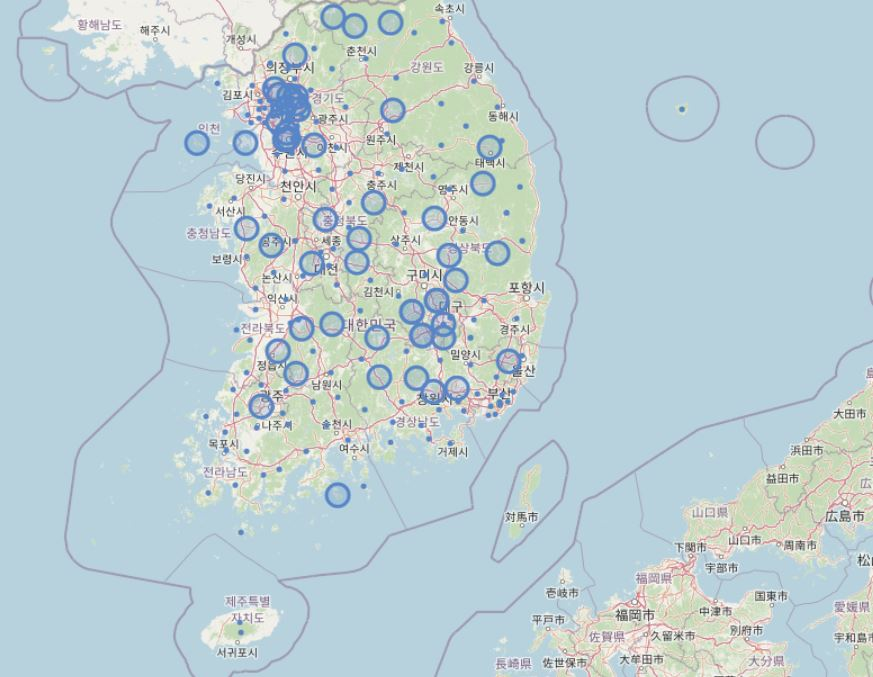

In [ ]:
Image("/content/drive/MyDrive/Dataton/Mecab_Folium_bubble_map.JPG", width= 873, height = 677)

###히트맵

In [ ]:
from folium import plugins
from folium.plugins import HeatMap

In [ ]:
heat_map = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)

heat_df = target_df[['Y', 'X']]

# List comprehension to make out list of lists
heat_data = [[row['Y'],row['X']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(heat_map)

# Display the map
heat_map

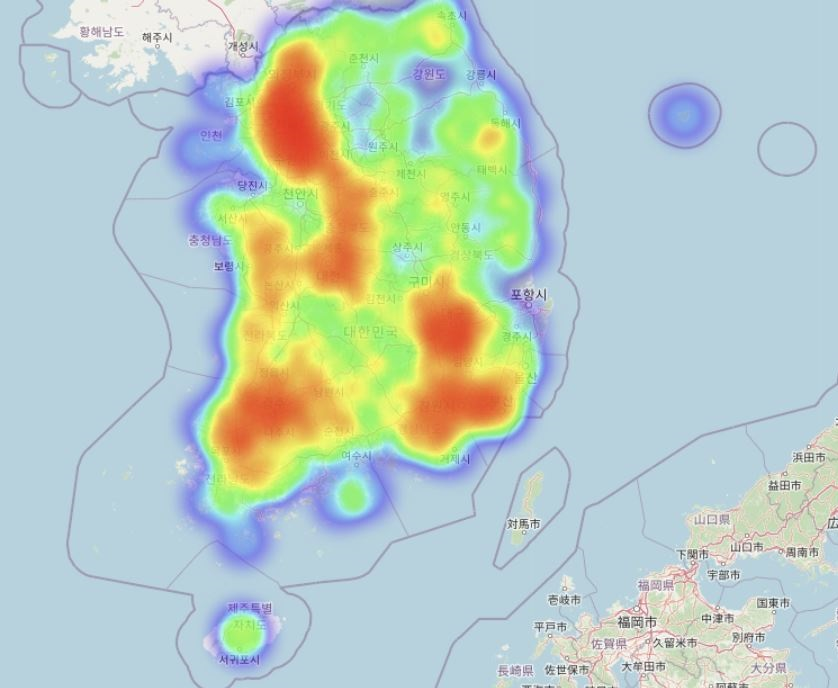

In [ ]:
Image("/content/drive/MyDrive/Dataton/Mecab_Folium_heat_map.JPG", width= 838, height = 688)

#Okt. Mecab 비교

##Mecab으로 분리된 단어 개수

In [ ]:
len(nouns_words_dict_csv)

12147

In [ ]:
nouns_words_dict_csv.head

<bound method NDFrame.head of         명사   빈도수
0       우리  2051
1       시간  1776
2       어디  1374
3       언니  1120
4       저녁  1066
...    ...   ...
12142  부작용     1
12143   강행     1
12144   학위     1
12145   운젠     1
12146   졸사     1

[12147 rows x 2 columns]>

In [ ]:
nouns_words_dict_csv[:50]

##원문과 요약문 - 코사인 유사도

참고 코드
<br/>딥 러닝을 이용한 자연어 처리 입문
<br/>https://wikidocs.net/24603

원문 대화에서 뽑아낸 명사들이 많이 포함될수록 코사인 유사도가 높다.

In [ ]:
revised_X_mecab_nouns_two 

In [ ]:
dialogue_nouns_series = pd.Series(revised_X_mecab_nouns_two)

In [ ]:
dialogue_nouns_series[:1]

0    [시스템, 사진, 비행, 시간, 비행기, 하루, 생각, 이때, 언제, 이번, 기회,...
dtype: object

In [ ]:
dialogue_nouns_words_df = pd.DataFrame(dialogue_nouns_series.reset_index())
dialogue_nouns_words_df.columns = ['index', 'dialogue_noun'] 

In [ ]:
for i in range(len(dialogue_nouns_words_df)):
  dialogue_nouns_words_df['dialogue_noun'][i] = set(dialogue_nouns_words_df['dialogue_noun'][i])
  dialogue_nouns_words_df['dialogue_noun'][i] = list(dialogue_nouns_words_df['dialogue_noun'][i])

**각 대화에서 추출한 명사 리스트에서 중복 단어 제거**

In [ ]:
type(dialogue_nouns_words_df["dialogue_noun"][0])

list

In [ ]:
for i in range(len(dialogue_nouns_words_df["dialogue_noun"])):
  dialogue_nouns_words_df["dialogue_noun"][i] = ' '.join(map(str, dialogue_nouns_words_df["dialogue_noun"][i]))

In [ ]:
dialogue_nouns_words_df[:5]

,index,dialogue_noun
0,0,비행 이번 이때 시스템 비행기 하루 사진 시간 결제 고고 기회 생각 언제
1,1,지경 가요 호텔 예약 옆방 어디
2,2,비어 웨이팅 숙숙 정류장 온기 번짼데 내림 테이블 하나 신호 거리 정도
3,3,저번 다구 우리 이틀
4,4,언니 사촌 아빠 그램 원주


In [ ]:
dialogue_nouns_words_df.to_csv('/content/drive/MyDrive/Dataton/dialogue_nouns_words.csv', index=False)

In [ ]:
dialogue_nouns_words_df = pd.read_csv("/content/drive/MyDrive/Dataton/dialogue_nouns_words.csv")

In [ ]:
event_summary_df = pd.read_csv("/content/drive/MyDrive/Dataton/event_summary.csv")

In [ ]:
event_summary_df

In [ ]:
event_summary_df['index'] = event_summary_df.index
event_summary_df = event_summary_df[['index', 'text']] 
event_summary_df.columns = ['index', 'summary']

In [ ]:
event_summary_df[:5]

,index,summary
0,0,비행시간이 엄청나게 오래 걸리기에 하루 잔다고 생각하기로 하고 결제를 하려고 한다.
1,1,20만 원이면 괜찮은 곳일 것 같은데 어느 호텔인지 궁금하다.
2,2,신호에 너무 많이 걸려 이제 내렸다고 하니까 앞에 한 팀이 더 있어 딱 맞게 올 거...
3,3,쉬는 날을 확보하기 위해 일정을 조정하기로 했다.
4,4,한 사람이 사촌 언니도 있고 아빠가 갑자기 원주에 가자고 해서 지금 원주에 갔다가 ...


In [ ]:
event_summary_df['summary'][1]

In [ ]:
text_comparision_df = pd.merge(dialogue_nouns_words_df, event_summary_df)

In [ ]:
text_comparision_df

,index,dialogue_noun,summary
0,0,비행 이번 이때 시스템 비행기 하루 사진 시간 결제 고고 기회 생각 언제,비행시간이 엄청나게 오래 걸리기에 하루 잔다고 생각하기로 하고 결제를 하려고 한다.
1,1,지경 가요 호텔 예약 옆방 어디,20만 원이면 괜찮은 곳일 것 같은데 어느 호텔인지 궁금하다.
2,2,비어 웨이팅 숙숙 정류장 온기 번짼데 내림 테이블 하나 신호 거리 정도,신호에 너무 많이 걸려 이제 내렸다고 하니까 앞에 한 팀이 더 있어 딱 맞게 올 거...
3,3,저번 다구 우리 이틀,쉬는 날을 확보하기 위해 일정을 조정하기로 했다.
4,4,언니 사촌 아빠 그램 원주,한 사람이 사촌 언니도 있고 아빠가 갑자기 원주에 가자고 해서 지금 원주에 갔다가 ...
...,...,...,...
9995,9995,코스 기본 동시 시작 요리 얼마 수작,코스 요리를 먹으면서 동시에 식을 보는 것인데 코스 요리가 기본 10만 원부터 시작...
9996,9996,성역 머리 양재 시인,내일 머리를 자른 후 삼성역에서 만나기로 한다.
9997,9997,건가요 데이트 어디 회사 장소 강행 여섯,오늘 데이트를 위해 6시 회사에서 만나기로 했다.
9998,9998,저번 이번 졸사 사진 졸업 취직 여름 그때 부자 머리 학위 운젠 졸업식 겨울,여름에 졸업사진을 찍으면 땀이 나서 머리가 다 망가진다.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
cos_sim_list = []

In [ ]:
for i in range(len(text_comparision_df)):
  text = []
  text.append(text_comparision_df['dialogue_noun'][i])
  text.append(text_comparision_df['summary'][i])
  
  count_vec = CountVectorizer()
  m = count_vec.fit_transform(text)
  m_array = m.toarray()
  cos_sim_list.append(cos_sim(m_array[0], m_array[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
cos_sim_df = pd.Series(cos_sim_list)

In [ ]:
cos_sim_df

0        0.083624
1        0.000000
2        0.000000
3        0.000000
4        0.100000
           ...   
19995    0.283473
19996    0.000000
19997    0.000000
19998    0.000000
19999    0.101015
Length: 20000, dtype: float64

최대 코사인 유사도 :  0.5773502691896258
평균 :  0.07304975128984709
표준편차 :  0.09379010664668129


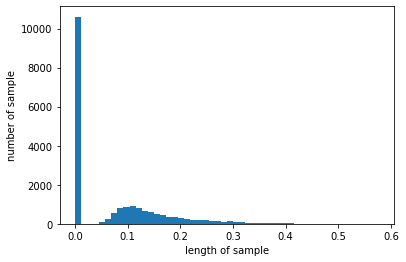

In [ ]:
print('최대 코사인 유사도 : ', np.max(cos_sim_df))
print('평균 : ', np.mean(cos_sim_df))
print('표준편차 : ', np.std(cos_sim_df))

plt.hist([s for s in cos_sim_df], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

#참고문헌

유원준 외 1명, 딥러닝을 이용한 자연어 처리 입문, wikidocs, 2022
<br/>[잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)](https://wikidocs.net/30708)
<br/>[코사인 유사도(Cosine Similarity)](https://wikidocs.net/24603)
<br/><br/>[카톡 데이터로 워드 클라우드 그리기](https://m.blog.naver.com/nilsine11202/221834254905)

<br/>[전국 인구 현황 지도 시각화](https://mkjjo.github.io/python/2019/08/18/korea_population.html)
<br/>[Folium을 이용한 데이타 시각화](https://blog.naver.com/PostView.nhn?blogId=kcchang61&logNo=221350672356)
<br/>[대한민국 최신 행정구역(SHP) 다운로드](http://www.gisdeveloper.co.kr/?p=2332)
<br/>[대한민국 행정구역 경계 JSON 파일 변환 및 다운받기](https://yeomss.tistory.com/267)
<br/>[대한민국 행정구역(시도, 시군구) GeoJSON 파일 다운로드 및 SHP 파일 단순화 후 변환 방법 설명](https://neurowhai.tistory.com/350)